
Evaluating model: GPT-4o-mini
  Spearman ρ = 0.725, p = 6.984e-103
  Pearson r  = 0.685, p = 1.564e-87
  Mean absolute diff (MAD): 0.834
  Mean signed diff (bias): 0.450
  Model SD (within-item, across runs): 0.354
  Human SD (given, SD column): mean=1.541, median=1.640 (N=624)
  Model SD on same items:       mean=0.354, median=0.383
  SD gap (model − human):       mean=-1.187
  % items where model SD < human SD: 97.8%

Evaluating model: O4-mini
  Spearman ρ = 0.753, p = 6.001e-115
  Pearson r  = 0.752, p = 7.314e-115
  Mean absolute diff (MAD): 0.951
  Mean signed diff (bias): 0.419
  Model SD (within-item, across runs): 0.535
  Human SD (given, SD column): mean=1.541, median=1.640 (N=624)
  Model SD on same items:       mean=0.535, median=0.518
  SD gap (model − human):       mean=-1.005
  % items where model SD < human SD: 95.0%

Evaluating model: LLaMA-3.3-70B
  Spearman ρ = 0.632, p = 8.374e-71
  Pearson r  = 0.590, p = 7.806e-60
  Mean absolute diff (MAD): 1.372
  Mean signed di

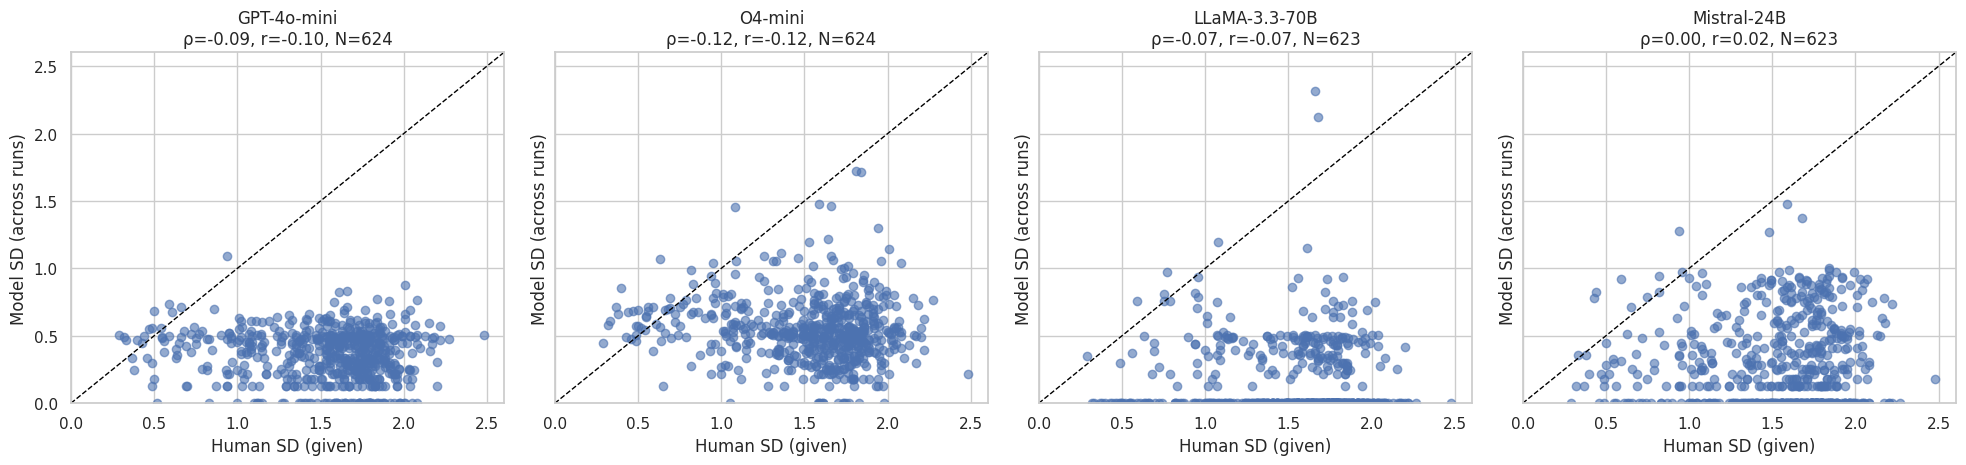

In [ ]:
import csv
import re
import unicodedata
from collections import defaultdict
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt

# ============================================================
# Utility functions
# ============================================================
def clean_numeric(value):
    """Extract numeric value from string, handle ',' as decimal separator."""
    if value is None:
        return np.nan
    s = str(value).strip()
    if not s:
        return np.nan
    s = re.sub(r"[^\d,\.]", "", s).replace(",", ".").strip()
    try:
        return float(s)
    except:
        return np.nan

def normalize_pair(pair):
    """
    Normalize wordPairs key so it matches between:
      - model results files
      - gold file (with SD)
    Handles: accents, quotes, dash variants, case, spaces around hyphen.
    """
    if not pair:
        return ""
    s = str(pair).strip()

    # unify dash variants
    s = s.replace("–", "-").replace("—", "-")

    # unify apostrophes/quotes
    s = s.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')

    # strip accents
    s = unicodedata.normalize("NFKD", s)
    s = s.encode("ascii", "ignore").decode("utf-8")

    # lowercase
    s = s.lower().strip()

    # normalize spaces around hyphen
    s = re.sub(r"\s*-\s*", "-", s)

    # collapse internal whitespace
    s = re.sub(r"\s+", " ", s)

    return s

# ============================================================
# Load GOLD human SD (and optionally gold means) ONCE
# ============================================================
def load_gold_human_sd(gold_file):
    """
    Load human SD values (already given in the SD column) from the original Lakzoum dataset.
    Returns:
      human_sd_gold: {normalized_word_pair: SD}
      gold_mean:     {normalized_word_pair: MeanPairSimilarity}   (optional but useful)
      gold_conc:     {normalized_word_pair: PairMeanConcreteness} (optional)
      gold_cluster:  {normalized_word_pair: clusters}             (optional)
    """
    human_sd_gold = {}
    gold_mean = {}
    gold_conc = {}
    gold_cluster = {}

    with open(gold_file, mode="r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            wp = normalize_pair(row.get("wordPairs"))
            if not wp:
                continue

            # SD (given)
            sd_raw = row.get("SD") or row.get("sd") or row.get("StdDev") or row.get("stddev")
            sd_val = clean_numeric(sd_raw)
            if not np.isnan(sd_val):
                human_sd_gold[wp] = sd_val

            # Mean similarity (gold mean)
            mean_sim_raw = (
                row.get("MeanPairSimilarity")
                or row.get("meanpairsimilarity")
                or row.get("MeanPairSimilarity.1")
                or row.get("PairSimilarity")
                or row.get("MeanPairSim")
            )
            mean_sim = clean_numeric(mean_sim_raw)
            if not np.isnan(mean_sim):
                gold_mean[wp] = mean_sim

            # Optional: PairMeanConcreteness
            conc = clean_numeric(row.get("PairMeanConcreteness"))
            if not np.isnan(conc):
                gold_conc[wp] = conc

            # Optional: clusters
            cl = row.get("clusters") or row.get("cluster")
            if cl is not None and str(cl).strip() != "":
                gold_cluster[wp] = str(cl).strip()

    return human_sd_gold, gold_mean, gold_conc, gold_cluster

# ============================================================
# Read model results CSVs
# ============================================================
def read_pairwise_list(results_file):
    """
    Reads a model results CSV and returns:
      - per_pair_ratings: {normalized_word_pair: [answers]}
      - pairs_gold_ratings: {normalized_word_pair: gold_similarity} (if present in file)
      - clusters: {normalized_word_pair: cluster}                   (if present in file)
      - concreteness: {normalized_word_pair: PairMeanConcreteness}  (if present in file)
    """
    pairs_gold_ratings = {}
    per_pair_ratings = defaultdict(list)
    clusters = {}
    concreteness = {}

    with open(results_file, mode='r', encoding='utf-8') as f:
        reader = csv.DictReader(f)

        for row in reader:
            wp_raw = row.get('wordPairs')
            wp = normalize_pair(wp_raw)
            if not wp:
                continue

            # Model answer column (robust)
            answer = row.get('models_answer') or row.get('Answer') or row.get('model_answer')
            if answer is None or str(answer).strip() == "":
                continue

            # Cluster (if present)
            cluster = row.get('clusters') or row.get('cluster') or 'unknown'
            clusters[wp] = cluster

            # Gold similarity if present (mean)
            mean_sim_raw = (
                row.get('MeanPairSimilarity')
                or row.get('meanpairsimilarity')
                or row.get('MeanPairSimilarity.1')
                or row.get('PairSimilarity')
                or row.get('MeanPairSim')
            )
            gold_sim = clean_numeric(mean_sim_raw)
            if not np.isnan(gold_sim):
                pairs_gold_ratings[wp] = gold_sim

            # PairMeanConcreteness if present
            conc = clean_numeric(row.get('PairMeanConcreteness'))
            if not np.isnan(conc):
                concreteness[wp] = conc

            per_pair_ratings[wp].append(answer)

    return per_pair_ratings, pairs_gold_ratings, clusters, concreteness

# ============================================================
# Evaluate all items per model (global)
# ============================================================
def evaluate_model_global(model_name, list_files, human_sd_gold_global, gold_mean_global=None,
                          gold_conc_global=None, gold_cluster_global=None):
    all_model = []
    all_gold = []

    cluster_stats = defaultdict(lambda: defaultdict(int))
    label_stats = {i: defaultdict(int) for i in range(8)}
    first_answer_correct = 0
    total_pairs = 0
    per_pair_diffs = {}
    mistakes_dict = defaultdict(list)

    # Accumulate across lists
    per_pair_ratings_all = defaultdict(list)

    # If results files contain gold info, we can read it; otherwise fall back to global gold means
    pairs_gold_ratings_all = {}
    clusters_all = {}
    concreteness_all = {}

    for results_file in list_files:
        per_pair_ratings, pairs_gold_ratings, clusters, concreteness = read_pairwise_list(results_file)

        # merge
        for wp, ans_list in per_pair_ratings.items():
            per_pair_ratings_all[wp].extend(ans_list)
        pairs_gold_ratings_all.update(pairs_gold_ratings)
        clusters_all.update(clusters)
        concreteness_all.update(concreteness)

        # per-file processing
        for wp, answers in per_pair_ratings.items():
            # Prefer gold in results file, else global gold mean if provided
            gold = pairs_gold_ratings_all.get(wp, np.nan)
            if np.isnan(gold) and gold_mean_global is not None:
                gold = gold_mean_global.get(wp, np.nan)

            if np.isnan(gold):
                continue

            total_pairs += 1
            first_answer_checked = False
            diffs = []

            for ans in answers:
                num_ans = clean_numeric(ans)
                if np.isnan(num_ans):
                    mistakes_dict[wp].append(ans)
                    continue

                all_model.append(num_ans)
                all_gold.append(gold)

                diff = abs(num_ans - gold)
                diffs.append(diff)

                # cluster label (prefer results, else gold cluster)
                cluster = clusters_all.get(wp, None)
                if (cluster is None or cluster == 'unknown') and gold_cluster_global is not None:
                    cluster = gold_cluster_global.get(wp, 'unknown')
                if cluster is None:
                    cluster = 'unknown'

                cluster_stats[cluster]['total'] += 1
                if diff < 0.1:
                    cluster_stats[cluster]['correct'] += 1
                elif diff < 0.9:
                    cluster_stats[cluster]['mistakes_01'] += 1
                elif diff < 1.9:
                    cluster_stats[cluster]['mistakes_12'] += 1
                elif diff < 2.9:
                    cluster_stats[cluster]['mistakes_23'] += 1
                elif diff < 3.9:
                    cluster_stats[cluster]['mistakes_34'] += 1
                else:
                    cluster_stats[cluster]['mistakes_4plus'] += 1

                label = min(max(int(round(num_ans)), 0), 7)
                label_stats[label]['total'] += 1
                if diff < 0.1:
                    label_stats[label]['correct'] += 1
                elif diff < 0.9:
                    label_stats[label]['mistakes_01'] += 1
                elif diff < 1.9:
                    label_stats[label]['mistakes_12'] += 1
                elif diff < 2.9:
                    label_stats[label]['mistakes_23'] += 1
                elif diff < 3.9:
                    label_stats[label]['mistakes_34'] += 1
                else:
                    label_stats[label]['mistakes_4plus'] += 1

                if not first_answer_checked:
                    if abs(num_ans - gold) < 0.1:
                        first_answer_correct += 1
                    first_answer_checked = True

            per_pair_diffs[wp] = diffs

    # -------------------------
    # Model within-item SD (computed across runs)
    # -------------------------
    per_pair_model_sd = {}
    pair_sds = []
    for wp, answers in per_pair_ratings_all.items():
        nums = [clean_numeric(a) for a in answers]
        nums = [x for x in nums if not np.isnan(x)]
        if len(nums) >= 2:
            sd = float(np.std(nums, ddof=1))
            per_pair_model_sd[wp] = sd
            pair_sds.append(sd)
    sd_model_within_mean = float(np.mean(pair_sds)) if pair_sds else np.nan

    # -------------------------
    # Option B correlation: stimulus-level means
    # -------------------------
    pair_model_means = []
    pair_gold_means = []

    for wp, answers in per_pair_ratings_all.items():
        gold = pairs_gold_ratings_all.get(wp, np.nan)
        if np.isnan(gold) and gold_mean_global is not None:
            gold = gold_mean_global.get(wp, np.nan)
        if np.isnan(gold):
            continue

        nums = [clean_numeric(a) for a in answers]
        nums = [x for x in nums if not np.isnan(x)]
        if not nums:
            continue

        pair_model_means.append(float(np.mean(nums)))
        pair_gold_means.append(float(gold))

    if len(pair_model_means) > 1:
        sp = spearmanr(pair_model_means, pair_gold_means)
        pe = pearsonr(pair_model_means, pair_gold_means)
        spearman_value, spearman_p = sp.statistic, sp.pvalue
        pearson_value, pearson_p = pe
    else:
        spearman_value, spearman_p, pearson_value, pearson_p = np.nan, np.nan, np.nan, np.nan

    # -------------------------
    # Global mean diffs (response-level)
    # -------------------------
    abs_diffs = [abs(m - h) for m, h in zip(all_model, all_gold)]
    signed_diffs = [m - h for m, h in zip(all_model, all_gold)]
    mean_abs = float(np.mean(abs_diffs)) if abs_diffs else np.nan
    mean_signed = float(np.mean(signed_diffs)) if signed_diffs else np.nan

    # -------------------------
    # Human SD (given) vs Model SD (computed)
    # Use human SD from global gold dict for ALL models
    # -------------------------
    common_pairs = [wp for wp in per_pair_model_sd if wp in human_sd_gold_global and np.isfinite(human_sd_gold_global[wp])]

    human_sd_vals = [float(human_sd_gold_global[wp]) for wp in common_pairs]
    model_sd_vals = [float(per_pair_model_sd[wp]) for wp in common_pairs]

    human_sd_summary = {
        "n_pairs_with_human_sd": len(common_pairs),
        "human_sd_mean_given": float(np.mean(human_sd_vals)) if human_sd_vals else np.nan,
        "human_sd_median_given": float(np.median(human_sd_vals)) if human_sd_vals else np.nan,
        "model_sd_mean_on_common": float(np.mean(model_sd_vals)) if model_sd_vals else np.nan,
        "model_sd_median_on_common": float(np.median(model_sd_vals)) if model_sd_vals else np.nan,
        "sd_gap_mean_model_minus_human": float(np.mean([m - h for m, h in zip(model_sd_vals, human_sd_vals)])) if human_sd_vals else np.nan,
        "pct_pairs_model_sd_lt_human_sd": float(100 * sum(m < h for m, h in zip(model_sd_vals, human_sd_vals)) / len(common_pairs)) if common_pairs else np.nan,
    }

    # -------------------------
    # Outliers at stimulus mean level (enriched)
    # -------------------------
    per_pair_model_mean = {}
    for wp, answers in per_pair_ratings_all.items():
        nums = [clean_numeric(a) for a in answers]
        nums = [x for x in nums if not np.isnan(x)]
        if nums:
            per_pair_model_mean[wp] = float(np.mean(nums))

    outlier_rows = []
    for wp, model_mean in per_pair_model_mean.items():
        gold = pairs_gold_ratings_all.get(wp, np.nan)
        if np.isnan(gold) and gold_mean_global is not None:
            gold = gold_mean_global.get(wp, np.nan)
        if np.isnan(gold):
            continue

        signed = float(model_mean - gold)
        mad = float(abs(signed))

        conc = concreteness_all.get(wp, np.nan)
        if np.isnan(conc) and gold_conc_global is not None:
            conc = gold_conc_global.get(wp, np.nan)

        cluster = clusters_all.get(wp, None)
        if (cluster is None or cluster == 'unknown') and gold_cluster_global is not None:
            cluster = gold_cluster_global.get(wp, 'unknown')
        if cluster is None:
            cluster = 'unknown'

        hsd = human_sd_gold_global.get(wp, np.nan)

        outlier_rows.append({
            "pair": wp,
            "mad": mad,
            "signed_diff": signed,
            "direction": "overestimate" if signed > 0 else ("underestimate" if signed < 0 else "match"),
            "gold": float(gold),
            "model_mean": float(model_mean),
            "PairMeanConcreteness": float(conc) if np.isfinite(conc) else np.nan,
            "HumanSD_given": float(hsd) if np.isfinite(hsd) else np.nan,
            "cluster": cluster
        })

    outlier_rows_sorted = sorted(outlier_rows, key=lambda d: d["mad"], reverse=True)
    top_outliers_detailed = outlier_rows_sorted[:10]
    top_outliers = [(d["pair"], d["mad"]) for d in top_outliers_detailed]

    over = [d for d in top_outliers_detailed if d["direction"] == "overestimate"]
    under = [d for d in top_outliers_detailed if d["direction"] == "underestimate"]

    def mean_conc(lst):
        vals = [x["PairMeanConcreteness"] for x in lst if np.isfinite(x["PairMeanConcreteness"])]
        return float(np.mean(vals)) if vals else np.nan

    outlier_summary = {
        "n_outliers": len(top_outliers_detailed),
        "n_overestimate": len(over),
        "n_underestimate": len(under),
        "mean_concreteness_over": mean_conc(over),
        "mean_concreteness_under": mean_conc(under)
    }

    return {
        "all_model": all_model,
        "all_gold": all_gold,
        "spearman": (spearman_value, spearman_p),
        "pearson": (pearson_value, pearson_p),
        "pair_model_means": pair_model_means,
        "pair_gold_means": pair_gold_means,
        "mean_abs_diff": mean_abs,
        "mean_signed_diff": mean_signed,
        "first_answer_accuracy": first_answer_correct / total_pairs * 100 if total_pairs else np.nan,
        "cluster_stats": cluster_stats,
        "label_stats": label_stats,
        "top_outliers": top_outliers,
        "top_outliers_detailed": top_outliers_detailed,
        "outlier_summary": outlier_summary,
        "per_pair_diffs": per_pair_diffs,
        "mistakes_dict": mistakes_dict,
        "sd_model_within_mean": sd_model_within_mean,
        "per_pair_model_sd": per_pair_model_sd,
        "human_sd_given_by_pair": human_sd_gold_global,  # same for all models
        "human_sd_summary": human_sd_summary,
    }

# ============================================================
# Plot: Human SD (given) vs Model SD (computed) per model
# ============================================================
def plot_human_vs_model_sd(global_results):
    n = len(global_results)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5), sharex=True, sharey=True)
    if n == 1:
        axes = [axes]

    # Collect global limits for comparable axes
    X_all, Y_all = [], []
    per_model_xy = {}

    for model, stats in global_results.items():
        human_sd = stats.get("human_sd_given_by_pair", {})  # gold dict
        model_sd = stats.get("per_pair_model_sd", {})       # computed dict

        common = [p for p in model_sd if p in human_sd and np.isfinite(human_sd[p])]
        x = np.array([float(human_sd[p]) for p in common], dtype=float)
        y = np.array([float(model_sd[p]) for p in common], dtype=float)

        mask = np.isfinite(x) & np.isfinite(y)
        x, y = x[mask], y[mask]

        per_model_xy[model] = (x, y)
        if x.size:
            X_all.append(x)
        if y.size:
            Y_all.append(y)

    if X_all and Y_all:
        x_all = np.concatenate(X_all) if len(X_all) > 1 else X_all[0]
        y_all = np.concatenate(Y_all) if len(Y_all) > 1 else Y_all[0]
        lim = float(max(np.nanmax(x_all), np.nanmax(y_all)) * 1.05)
    else:
        lim = 1.0

    for ax, (model, (x, y)) in zip(axes, per_model_xy.items()):
        if x.size == 0:
            ax.set_title(f"{model}\n(no SD overlap)")
            ax.set_xlabel("Human SD (given)")
            ax.set_ylabel("Model SD (runs)")
            ax.set_xlim(0, lim)
            ax.set_ylim(0, lim)
            continue

        sp = spearmanr(x, y)
        pe = pearsonr(x, y)

        ax.scatter(x, y, alpha=0.6)
        ax.plot([0, lim], [0, lim], linestyle="--", color="black", linewidth=1)

        ax.set_title(f"{model}\nρ={sp.statistic:.2f}, r={pe.statistic:.2f}, N={len(x)}", fontsize=12)
        ax.set_xlabel("Human SD (given)", fontsize=12)
        ax.set_ylabel("Model SD (across runs)", fontsize=12)
        ax.tick_params(axis='both', labelsize=11)
        ax.set_xlim(0, lim)
        ax.set_ylim(0, lim)

    plt.tight_layout()
    plt.show()

# ============================================================
# CONFIG (do not change result file names)
# ============================================================
model_files = {
    "GPT-4o-mini": [
        "list1_Lakhzoum_gpt-40-mini_fewshot.csv",
        "list2_Lakhzoum_gpt-40-mini_fewshot.csv",
        "list3_Lakhzoum_gpt-40-mini_fewshot.csv",
        "list4_Lakhzoum_gpt-40-mini_fewshot.csv",
        "list5_Lakhzoum_gpt-40-mini_fewshot.csv",
        "list6_Lakhzoum_gpt-40-mini_fewshot.csv"
    ],
    "O4-mini": [
        "list1_Lakhzoum_o4-mini_fewshot.csv",
        "list2_Lakhzoum_o4-mini_fewshot.csv",
        "list3_Lakhzoum_o4-mini_fewshot.csv",
        "list4_Lakhzoum_o4-mini_fewshot.csv",
        "list6_Lakhzoum_o4-mini_fewshot.csv",
        "list5_Lakhzoum_o4-mini_fewshot.csv"
    ],
    "LLaMA-3.3-70B": [
        "list1_Lakhzoum_llama_fewshot_t0.3.csv",
        "list2_Lakhzoum_llama_fewshot_t0.3.csv",
        "list3_Lakhzoum_llama_fewshot_t0.3.csv",
        "list4_Lakhzoum_llama_fewshot_t0.3.csv",
        "list5_Lakhzoum_llama_fewshot_t0.3.csv",
        "list6_Lakhzoum_llama_fewshot_t0.3.csv"
    ],
    "Mistral-24B": [
        "list1_Lakhzoum_mistral_fewshot_t0.3.csv",
        "list2_Lakhzoum_mistral_fewshot_t0.3.csv",
        "list3_Lakhzoum_mistral_fewshot_t0.3.csv",
        "list4_Lakhzoum_mistral_fewshot_t0.3.csv",
        "list5_Lakhzoum_mistral_fewshot_t0.3.csv",
        "list6_Lakhzoum_mistral_fewshot_t0.3.csv"
    ]
}

def format_pval(p):
    if p is None or np.isnan(p):
        return "NA"
    if p == 0:
        return "≈0"
    return f"{p:.3e}"

# ============================================================
# IMPORTANT: set this to your ORIGINAL Lakzoum gold CSV that contains the SD column
# (This is the one place you must provide a path.)
# ============================================================
gold_file_with_sd = "630similarFrenchWordPair.csv"

# Load gold SD once (shared across all models)
human_sd_gold_global, gold_mean_global, gold_conc_global, gold_cluster_global = load_gold_human_sd(gold_file_with_sd)

# ============================================================
# Run evaluation
# ============================================================
global_results = {}

for model_name, files in model_files.items():
    print(f"\nEvaluating model: {model_name}")
    stats = evaluate_model_global(
        model_name,
        files,
        human_sd_gold_global=human_sd_gold_global,
        gold_mean_global=gold_mean_global,
        gold_conc_global=gold_conc_global,
        gold_cluster_global=gold_cluster_global
    )
    global_results[model_name] = stats

    spearman_value, spearman_p = stats["spearman"]
    pearson_value, pearson_p = stats["pearson"]

    print(f"  Spearman ρ = {spearman_value:.3f}, p = {format_pval(spearman_p)}")
    print(f"  Pearson r  = {pearson_value:.3f}, p = {format_pval(pearson_p)}")
    print(f"  Mean absolute diff (MAD): {stats['mean_abs_diff']:.3f}")
    print(f"  Mean signed diff (bias): {stats['mean_signed_diff']:.3f}")
    print(f"  Model SD (within-item, across runs): {stats['sd_model_within_mean']:.3f}")

    hs = stats.get("human_sd_summary", {})
    if hs and hs.get("n_pairs_with_human_sd", 0) > 0:
        print(f"  Human SD (given, SD column): mean={hs['human_sd_mean_given']:.3f}, "
              f"median={hs['human_sd_median_given']:.3f} (N={hs['n_pairs_with_human_sd']})")
        print(f"  Model SD on same items:       mean={hs['model_sd_mean_on_common']:.3f}, "
              f"median={hs['model_sd_median_on_common']:.3f}")
        print(f"  SD gap (model − human):       mean={hs['sd_gap_mean_model_minus_human']:.3f}")
        print(f"  % items where model SD < human SD: {hs['pct_pairs_model_sd_lt_human_sd']:.1f}%")

# Plot SD comparison figure
plot_human_vs_model_sd(global_results)


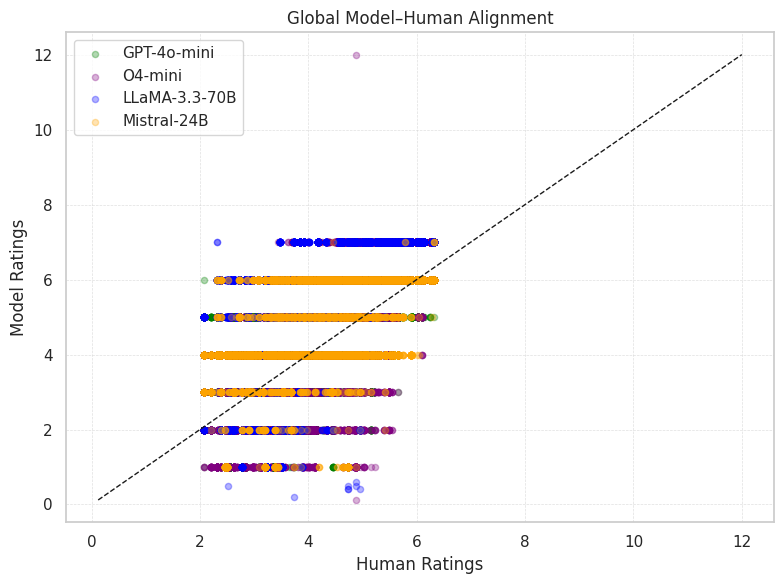

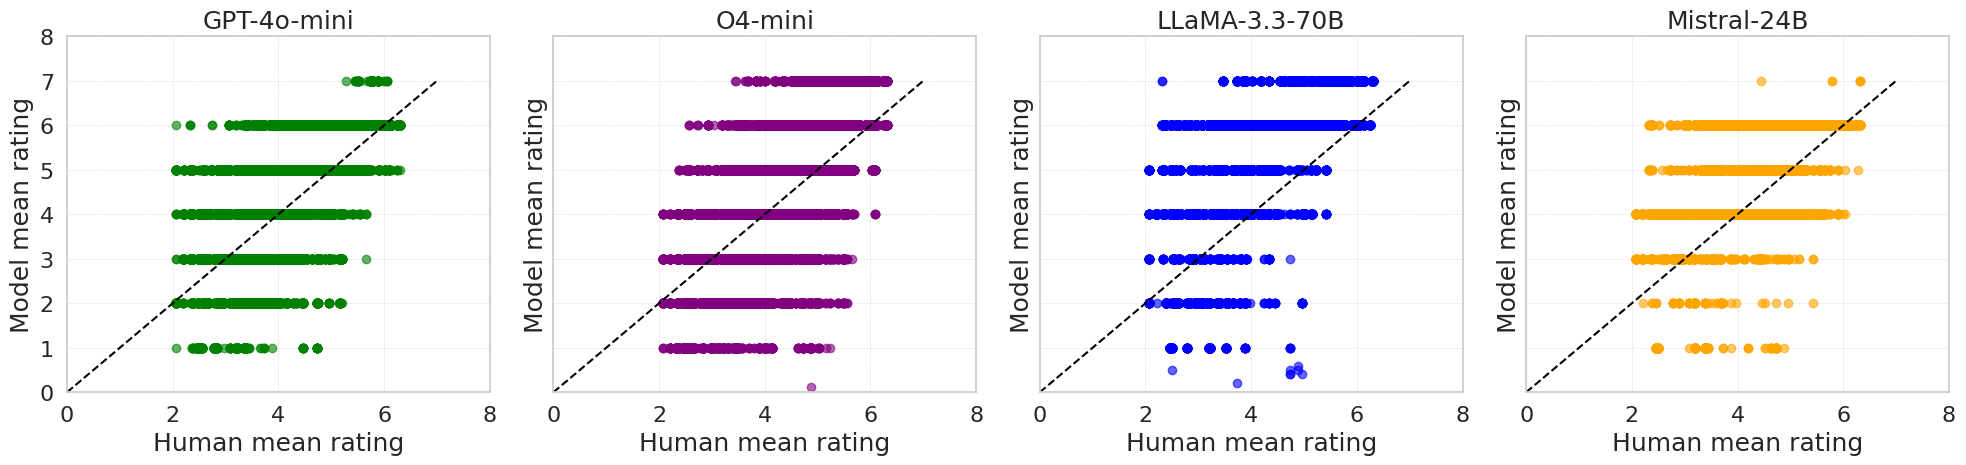

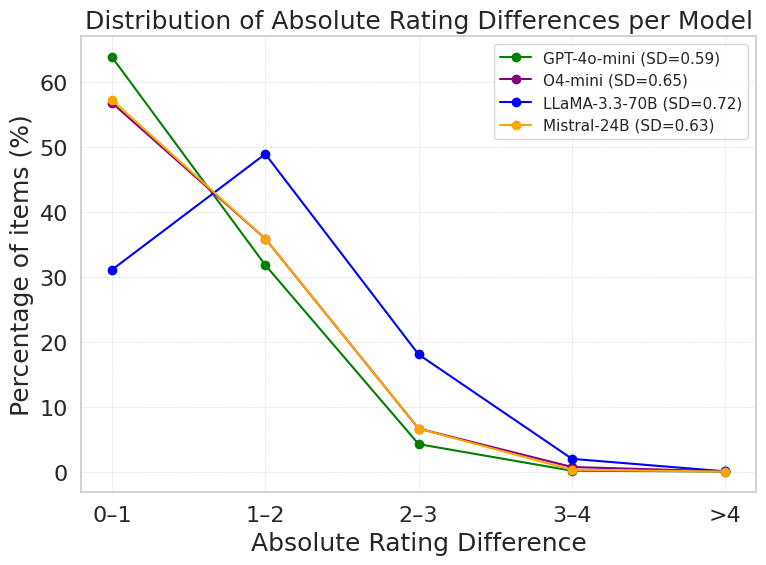

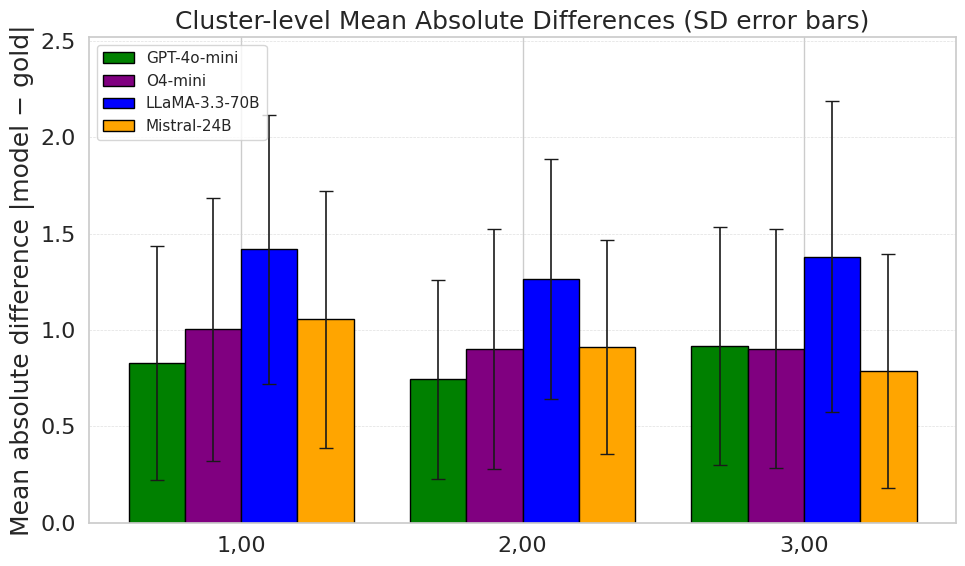

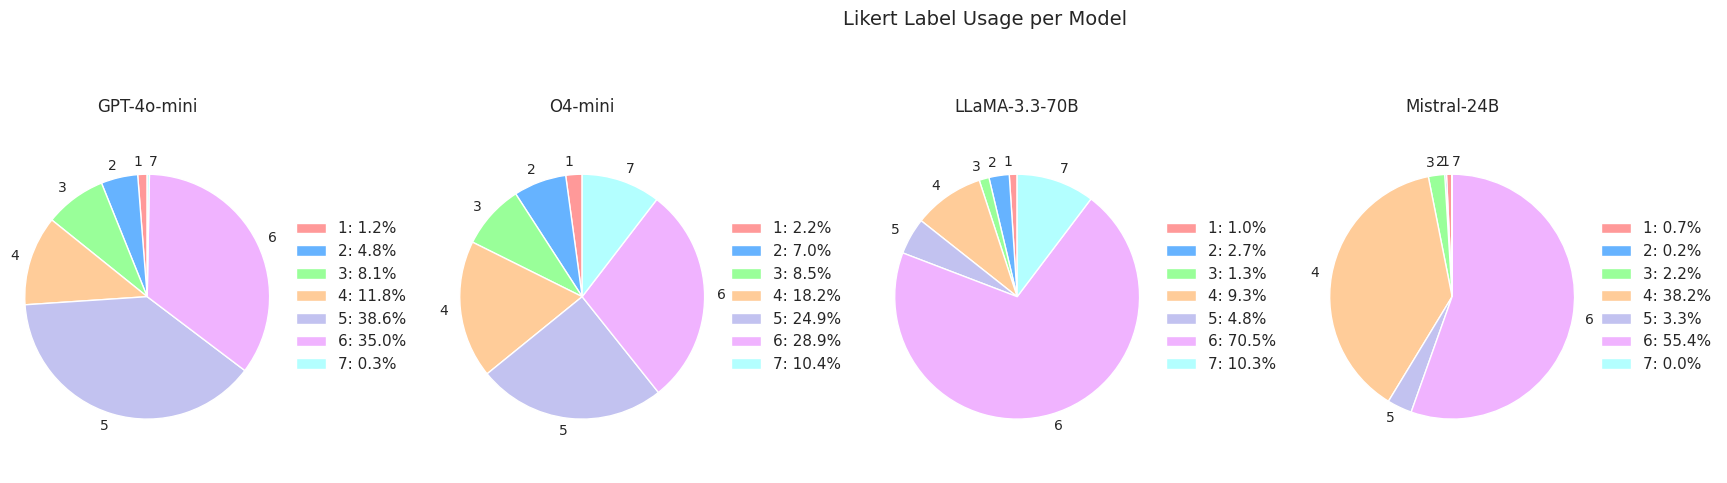

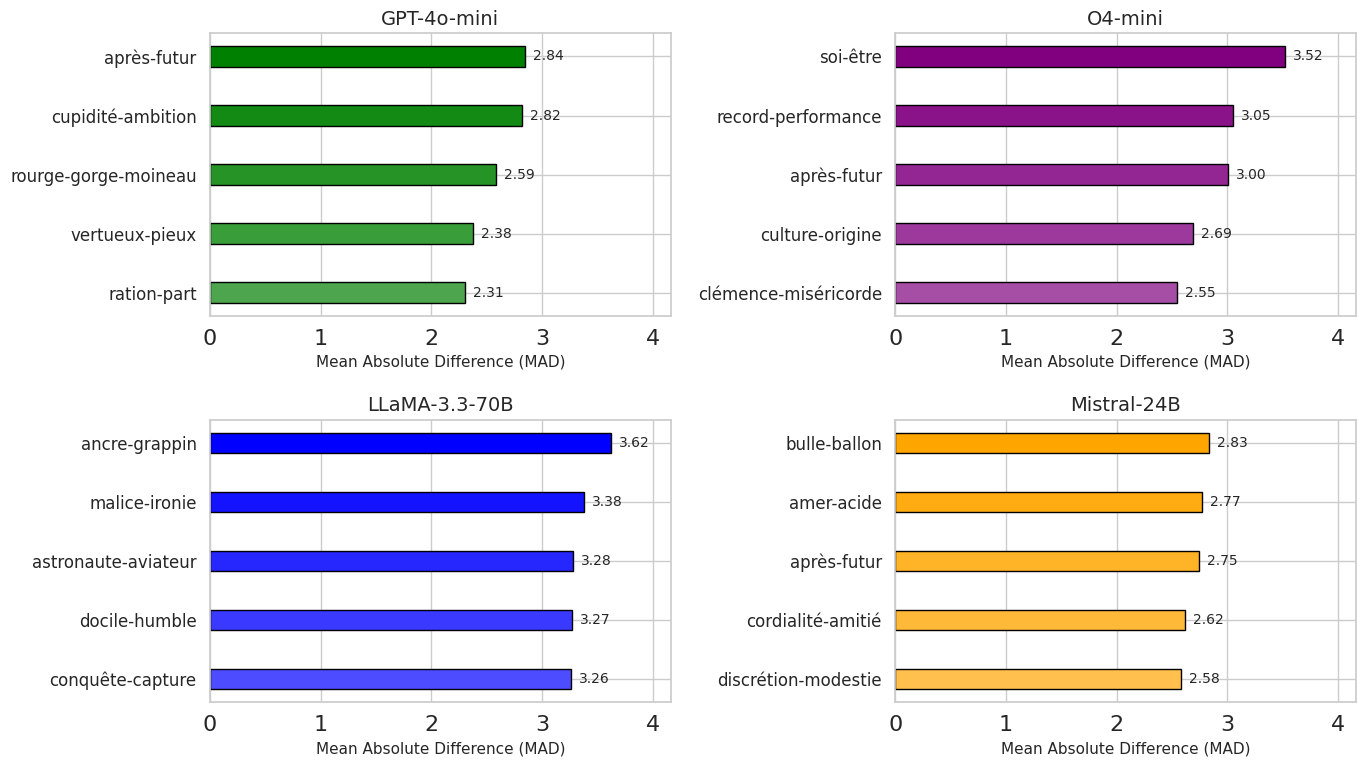

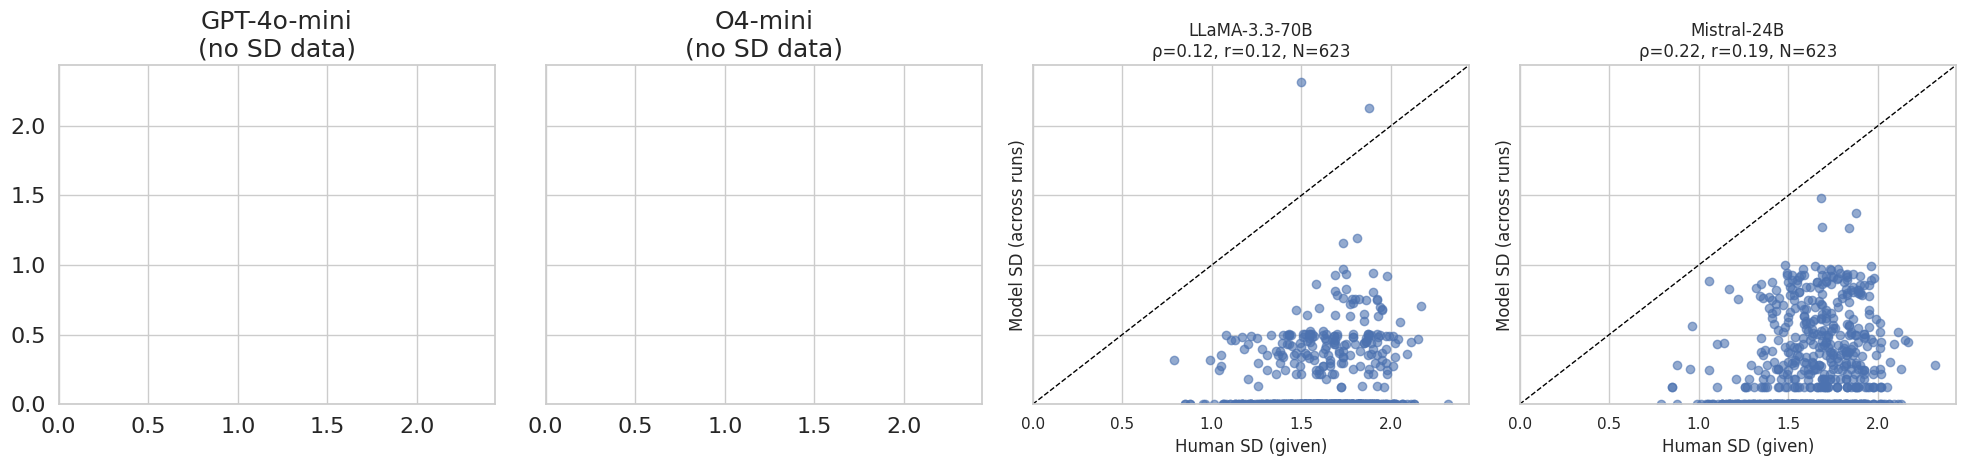

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter, defaultdict

sns.set(style="whitegrid")

# -------------------------
# 1️⃣ Global Model-Human Alignment (scatter + correlation)
# -------------------------
def plot_model_human_alignment(global_results):
    import matplotlib.pyplot as plt
    import numpy as np

    color_map = {
        "GPT-4o-mini": "green",
        "O4-mini": "purple",
        "LLaMA-3.3-70B": "blue",
        "Mistral-24B": "orange"
    }

    plt.figure(figsize=(8, 6))

    all_vals = []

    for model, stats in global_results.items():
        all_gold = np.array(stats['all_gold'])
        all_model = np.array(stats['all_model'])

        all_vals.extend(all_gold)
        all_vals.extend(all_model)

        plt.scatter(
            all_gold,
            all_model,
            alpha=0.3,
            s=20,
            label=model,
            color=color_map.get(model, "#808080")
        )

    # Identity line
    lo = min(all_vals)
    hi = max(all_vals)
    plt.plot([lo, hi], [lo, hi], 'k--', lw=1)

    plt.xlabel("Human Ratings")
    plt.ylabel("Model Ratings")
    plt.title("Global Model–Human Alignment")
    plt.legend()
    plt.grid(True, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_model_human_alignment_per_model(results_by_model):
    import matplotlib.pyplot as plt
    import numpy as np

    # Global font size
    plt.rcParams.update({
        "font.size": 18,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    })

    color_map = {
        "GPT-4o-mini": "green",
        "O4-mini": "purple",
        "LLaMA-3.3-70B": "blue",
        "Mistral-24B": "orange"
    }

    n = len(results_by_model)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5), sharex=True, sharey=True)

    if n == 1:
        axes = [axes]

    for ax, (model, data) in zip(axes, results_by_model.items()):

        if isinstance(data, dict) and 'all_gold' in data and 'all_model' in data:
            all_gold = np.array(data['all_gold'])
            all_model = np.array(data['all_model'])
        else:
            all_gold = np.array([x['mean_gold'] for x in data])
            all_model = np.array([x['mean_model'] for x in data])

        # Scatter
        ax.scatter(
            all_gold,
            all_model,
            alpha=0.6,
            color=color_map.get(model, "#808080")
        )

        # Identity line
        ax.plot([0, 7], [0, 7], linestyle="--", color="black")

        # Axes start at 0
        ax.set_xlim(0, 8)
        ax.set_ylim(0, 8)

        # Grid
        ax.grid(True, color="lightgray", linestyle="--", linewidth=0.5, alpha=0.7)

        # Labels
        ax.set_title(model)
        ax.set_xlabel("Human mean rating")
        ax.set_ylabel("Model mean rating")

    plt.tight_layout()
    plt.show()



# -------------------------
# 2️⃣ Distribution of Absolute Rating Differences (binned)
# -------------------------
def plot_abs_diff_distribution(global_results, bins=[0,0.1,0.9,1.9,2.9,3.9,10]):
    import matplotlib.pyplot as plt
    import numpy as np

    # Define explicit colors per model
    color_map = {
        "GPT-4o-mini": "green",
        "O4-mini": "purple",
        "LLaMA-3.3-70B": "blue",
        "Mistral-24B": "orange"
    }

    plt.figure(figsize=(8,6))

    # Fixed visualization bins
    labels = ["0–1", "1–2", "2–3", "3–4", ">4"]
    bins = [0, 1, 2, 3, 4, 10]  # numeric bin edges
    x = range(len(labels))

    for model, stats in global_results.items():
        diffs = np.abs(np.array(stats['all_model']) - np.array(stats['all_gold']))
        hist, _ = np.histogram(diffs, bins=bins)
        hist_perc = hist / sum(hist) * 100
        sd_diff = np.std(diffs)

        plt.plot(
            x,
            hist_perc,
            marker='o',
            label=f"{model} (SD={sd_diff:.2f})",
            color=color_map.get(model, "#808080")
        )

    plt.xticks(x, labels)  # Use the exact labels
    plt.xlabel("Absolute Rating Difference")
    plt.ylabel("Percentage of items (%)")
    plt.title("Distribution of Absolute Rating Differences per Model")
    plt.legend()
    plt.grid(True, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()



# -------------------------
# 3️⃣ Cluster-level accuracy / mean Δ
# -------------------------
def plot_cluster_stats(global_results):
    import matplotlib.pyplot as plt
    import numpy as np

    color_map = {
        "GPT-4o-mini": "green",
        "O4-mini": "purple",
        "LLaMA-3.3-70B": "blue",
        "Mistral-24B": "orange"
    }

    # Collect all cluster labels across models
    all_clusters_set = set()
    for stats in global_results.values():
        all_clusters_set.update(stats.get("all_clusters", []))
    all_clusters = sorted(all_clusters_set)

    if not all_clusters:
        raise ValueError("No cluster labels found. Make sure evaluate_model_global returns 'all_clusters'.")

    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.20
    x = np.arange(len(all_clusters))

    max_height = 0

    for i, (model, stats) in enumerate(global_results.items()):
        all_model = np.array(stats["all_model"], dtype=float)
        all_gold = np.array(stats["all_gold"], dtype=float)
        clusters = np.array(stats["all_clusters"])

        # Absolute diffs for every observation
        diffs = np.abs(all_model - all_gold)

        means = []
        sds = []

        for cl in all_clusters:
            mask = (clusters == cl)
            cl_diffs = diffs[mask]

            if cl_diffs.size == 0:
                means.append(np.nan)
                sds.append(0.0)
            else:
                means.append(float(np.mean(cl_diffs)))
                # SD across observations in this cluster (not within-item SD)
                sds.append(float(np.std(cl_diffs, ddof=1)) if cl_diffs.size >= 2 else 0.0)

        bars = ax.bar(
            x + i * width,
            means,
            width=width,
            yerr=sds,
            capsize=5,
            label=model,
            color=color_map.get(model, "#808080"),
            edgecolor="black",
            error_kw={"elinewidth": 1.2}
        )

        # track y-limit
        for m, sd in zip(means, sds):
            if not np.isnan(m):
                max_height = max(max_height, m + sd)

    ax.set_xticks(x + width * (len(global_results) - 1) / 2)
    ax.set_xticklabels(all_clusters)
    ax.set_ylabel("Mean absolute difference |model − gold|")
    ax.set_title("Cluster-level Mean Absolute Differences (SD error bars)")
    ax.grid(True, axis="y", color="lightgray", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.legend()

    if max_height > 0:
        ax.set_ylim(0, max_height * 1.15)

    plt.tight_layout()
    plt.show()


# -------------------------
# 4️⃣ Likert / Rating Label Usage
# -------------------------
def plot_likert_usage(global_results, max_label=7):
    import matplotlib.pyplot as plt
    from collections import Counter
    import numpy as np

    # Custom colors avoiding orange, blue, purple, green
    color_palette = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#f0b3ff', '#b3ffff', '#ffd699']

    labels = list(range(1, max_label + 1))  # 1–7
    n = len(global_results)

    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))

    if n == 1:
        axes = [axes]

    for ax, (model, stats) in zip(axes, global_results.items()):
        counts = Counter()
        for label, data in stats['label_stats'].items():
            if label in labels:
                counts[label] = data['total']

        sizes = [counts[l] for l in labels]
        total = sum(sizes)

        # Pie with 1–7 labels ON slices
        wedges, texts = ax.pie(
            sizes,
            labels=[str(l) for l in labels],   # show 1–7 on pie
            colors=color_palette[:len(labels)],
            startangle=90,
            textprops={'fontsize': 10},
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
        )

        # Legend with percentages (outside)
        legend_labels = [
            f"{l}: {sizes[i]/total*100:.1f}%" if total else f"{l}: 0.0%"
            for i, l in enumerate(labels)
        ]

        ax.legend(
            wedges,
            legend_labels,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            frameon=False
        )

        ax.set_title(model, fontsize=12, fontweight='normal')
        ax.axis('equal')

    plt.suptitle("Likert Label Usage per Model", fontsize=14, fontweight='normal')
    plt.tight_layout(rect=[0, 0, 0.88, 0.95])
    plt.show()

# -------------------------
# 5️⃣ Top Outlier Items
# -------------------------
def plot_top_outliers(global_results, top_n=5):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import to_rgb

    # Base colors per model (match your palette)
    color_map = {
        "GPT-4o-mini": "green",
        "O4-mini": "purple",
        "LLaMA-3.3-70B": "blue",
        "Mistral-24B": "orange"
    }

    # Order for consistent subplot placement
    model_order = ["GPT-4o-mini", "O4-mini", "LLaMA-3.3-70B", "Mistral-24B"]

    def lighten_color(color, amount):
        c = np.array(to_rgb(color))
        return tuple(c + (1 - c) * amount)

    # Collect global max for consistent x-axis
    global_max = 0
    for model in model_order:
        stats = global_results.get(model, {})
        outs = stats.get('top_outliers', [])
        if outs:
            top_items = sorted(outs, key=lambda x: x[1], reverse=True)[:top_n]
            global_max = max(global_max, max(d for _, d in top_items))

    # Create 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    axes = axes.flatten()

    for ax, model in zip(axes, model_order):
        stats = global_results.get(model, {})
        outs = stats.get('top_outliers', [])
        if not outs:
            ax.set_title(model)
            ax.text(0.5, 0.5, "No outliers found", ha='center', va='center')
            ax.axis("off")
            continue

        # Ensure sorted
        top_items = sorted(outs, key=lambda x: x[1], reverse=True)[:top_n]
        items, diffs = zip(*top_items)

        base_color = color_map.get(model, "#808080")

        # Light shading from darkest (largest diff) to lighter (smaller diff)
        shades = [
            lighten_color(base_color, amount)
            for amount in np.linspace(0.0, 0.3, len(diffs))
        ]

        bars = ax.barh(
            items,
            diffs,
            color=shades,
            edgecolor='black',
            height=0.35
        )

        # Put highest on top
        ax.invert_yaxis()

        # Add MAD values at end of each bar
        for bar in bars:
            w = bar.get_width()
            ax.text(
                w + (global_max * 0.02),
                bar.get_y() + bar.get_height()/2,
                f"{w:.2f}",
                va='center',
                fontsize=10
            )

        ax.set_xlim(0, global_max * 1.15)
        ax.set_title(model, fontsize=14)
        ax.set_xlabel("Mean Absolute Difference (MAD)", fontsize=11)
        ax.tick_params(axis='y', labelsize=12)

    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, pearsonr

def plot_human_vs_model_sd(global_results):
    """
    Scatter plot: Human SD (from dataset SD column) vs Model SD (within-item across runs),
    one panel per model.
    """
    n = len(global_results)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5), sharex=True, sharey=True)
    if n == 1:
        axes = [axes]

    # Gather global limits (so all panels comparable)
    all_x, all_y = [], []
    per_model_xy = {}

    for model, stats in global_results.items():
        human_sd = stats.get("human_sd_given_by_pair", {})
        model_sd = stats.get("per_pair_model_sd", {})

        common = [p for p in model_sd if p in human_sd and not np.isnan(human_sd[p])]
        x = np.array([float(human_sd[p]) for p in common], dtype=float)
        y = np.array([float(model_sd[p]) for p in common], dtype=float)

        # keep only finite
        mask = np.isfinite(x) & np.isfinite(y)
        x, y = x[mask], y[mask]

        per_model_xy[model] = (x, y)
        all_x.append(x)
        all_y.append(y)

    if all_x and all_y:
        x_all = np.concatenate(all_x) if len(all_x) > 1 else all_x[0]
        y_all = np.concatenate(all_y) if len(all_y) > 1 else all_y[0]
        xmax = float(np.nanmax(x_all)) if x_all.size else 1.0
        ymax = float(np.nanmax(y_all)) if y_all.size else 1.0
        lim = max(xmax, ymax) * 1.05
    else:
        lim = 1.0

    # Plot each model
    for ax, (model, (x, y)) in zip(axes, per_model_xy.items()):
        if x.size == 0:
            ax.set_title(f"{model}\n(no SD data)")
            continue

        # correlation between human SD and model SD (optional diagnostic)
        sp = spearmanr(x, y)
        pe = pearsonr(x, y)

        ax.scatter(x, y, alpha=0.6)  # default color
        ax.plot([0, lim], [0, lim], linestyle="--", color="black", linewidth=1)  # identity line

        ax.set_title(f"{model}\nρ={sp.statistic:.2f}, r={pe.statistic:.2f}, N={len(x)}", fontsize=12)
        ax.set_xlabel("Human SD (given)", fontsize=12)
        ax.set_ylabel("Model SD (across runs)", fontsize=12)
        ax.tick_params(axis='both', labelsize=11)
        ax.set_xlim(0, lim)
        ax.set_ylim(0, lim)

    plt.tight_layout()
    plt.show()



# Example usage:
plot_model_human_alignment(global_results)
plot_model_human_alignment_per_model(global_results)
plot_abs_diff_distribution(global_results)
plot_cluster_stats(global_results)
plot_likert_usage(global_results)
plot_top_outliers(global_results, top_n=5)
plot_human_vs_model_sd(global_results)
